In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte


 Image Reconstruction

In [3]:
## load the libraries 
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

In [5]:
train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1)

## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [6]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [7]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1177500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)             

In [8]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=25, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Epoch 1/25
27/27 [==============================] - 11s 413ms/step - loss: 0.0910 - val_loss: 0.0695
Epoch 2/25
27/27 [==============================] - 11s 418ms/step - loss: 0.0607 - val_loss: 0.0492
Epoch 3/25
27/27 [==============================] - 11s 411ms/step - loss: 0.0436 - val_loss: 0.0402
Epoch 4/25
27/27 [==============================] - 11s 409ms/step - loss: 0.0379 - val_loss: 0.0365
Epoch 5/25
27/27 [==============================] - 11s 409ms/step - loss: 0.0348 - val_loss: 0.0332
Epoch 6/25
27/27 [==============================] - 11s 416ms/step - loss: 0.0319 - val_loss: 0.0307
Epoch 7/25
27/27 [==============================] - 11s 421ms/step - loss: 0.0306 - val_loss: 0.0297
Epoch 8/25
27/27 [==============================] - 11s 412ms/step - loss: 0.0275 - val_loss: 0.0261
Epoch 9/25
27/27 [==============================] - 11s 411ms/step - loss: 0.0251 - val_loss: 0.0245
Epoch 10/25
27/27 [==============================] - 11s 409ms/step - loss: 0.0239 - val_lo

In [9]:
preds = model.predict(val_x)

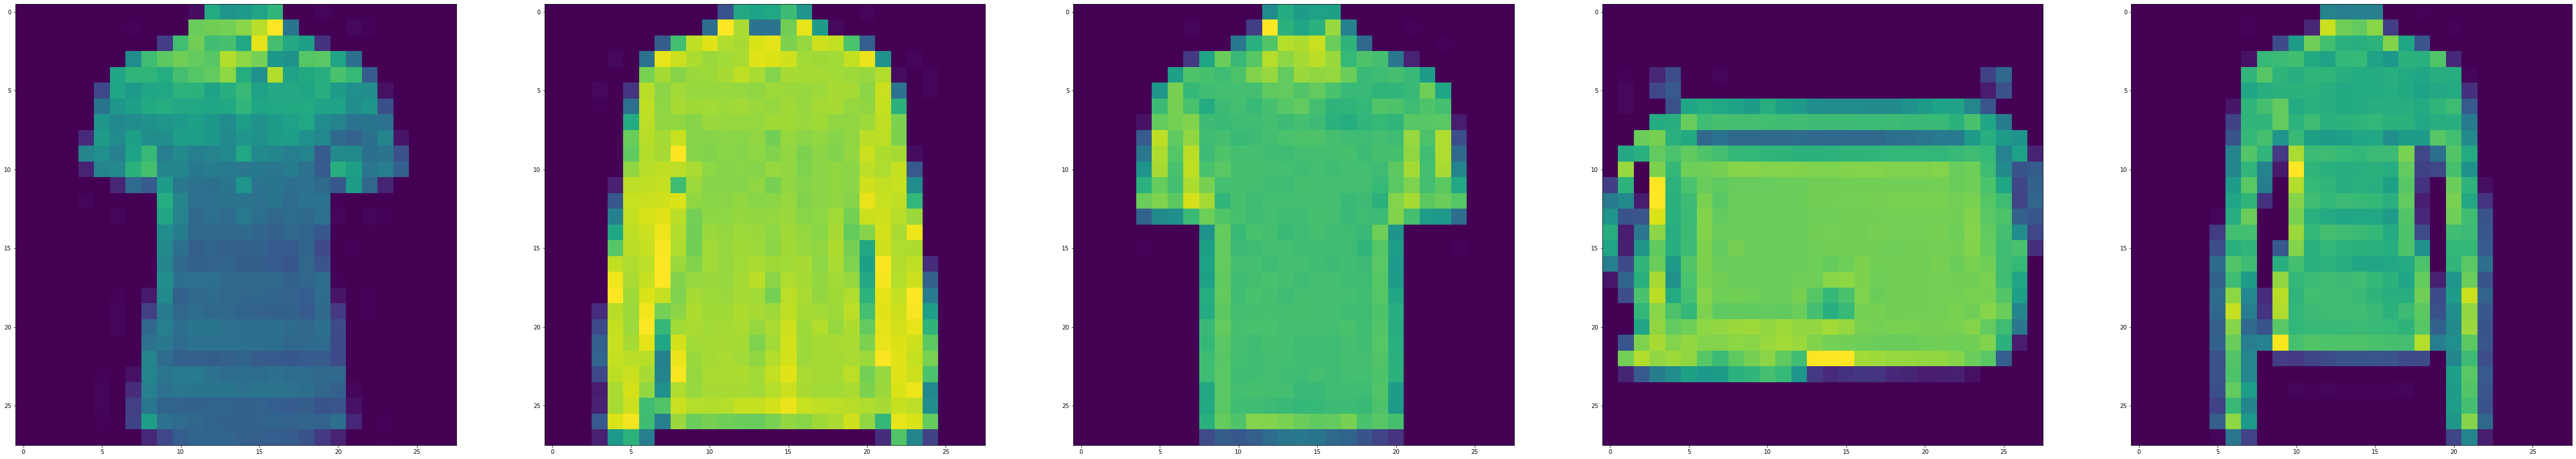

In [10]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

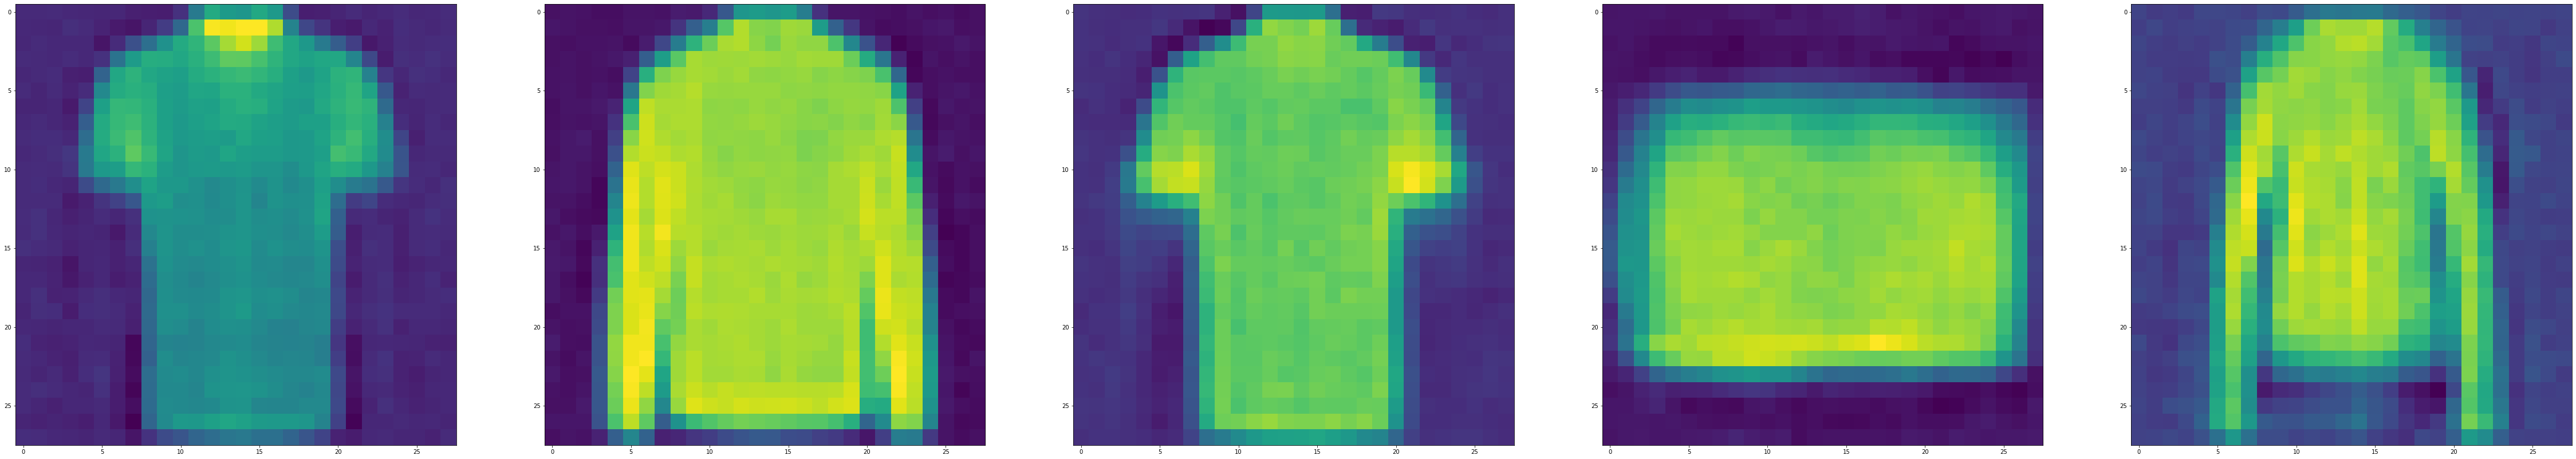

In [11]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

Image Denoising

In [12]:
## recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.1)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In [13]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

**Noisy Images
We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example:

Salt and Pepper Noise
Gaussian Noise
Periodic Noise
Speckle Noise
Lets introduce salt and pepper noise to our data which is also known as impulse noise. This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels.**

Before adding noise

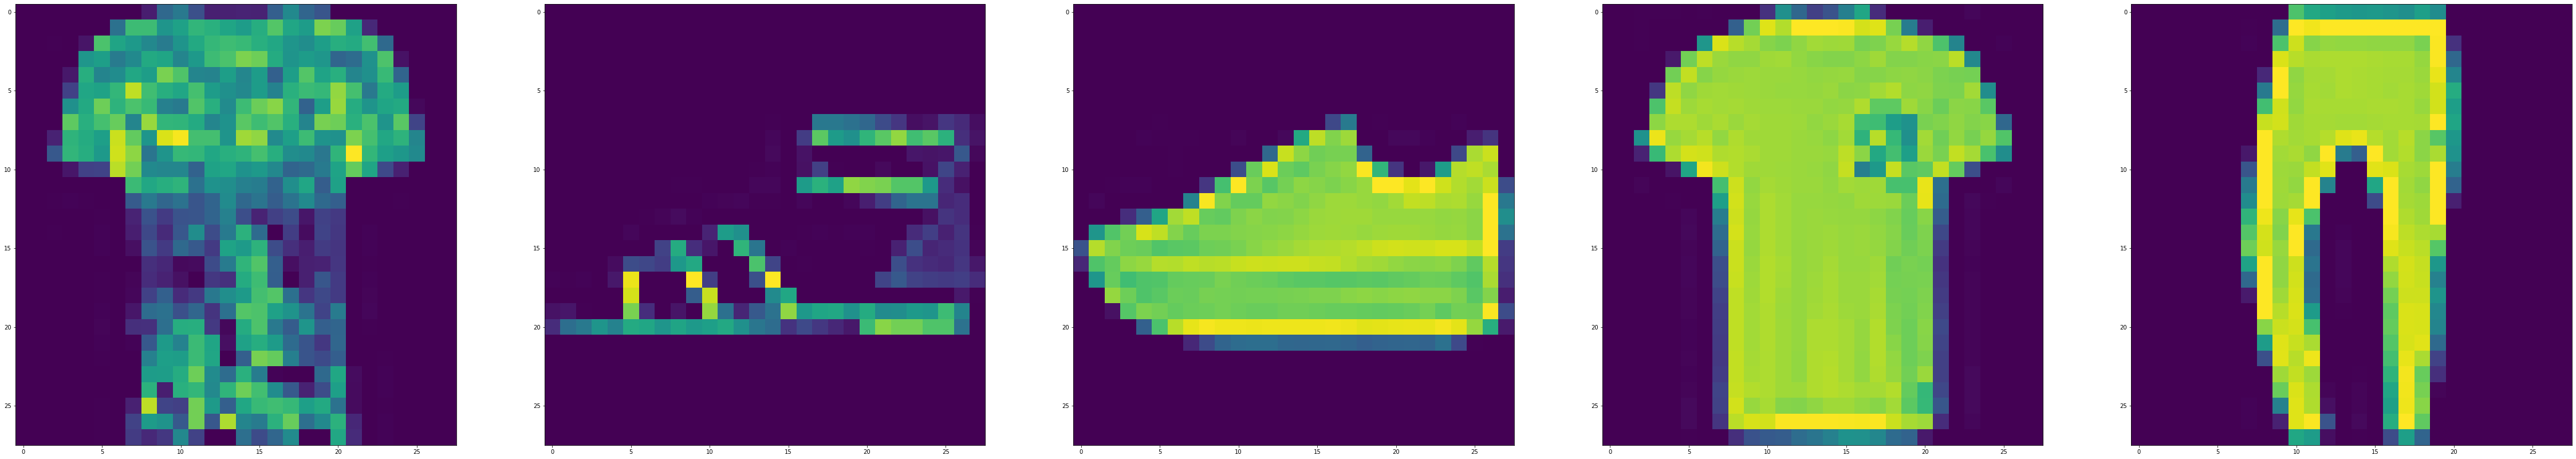

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

After adding noise

In [17]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x)
val_x_n = seq_object.augment_images(val_x)

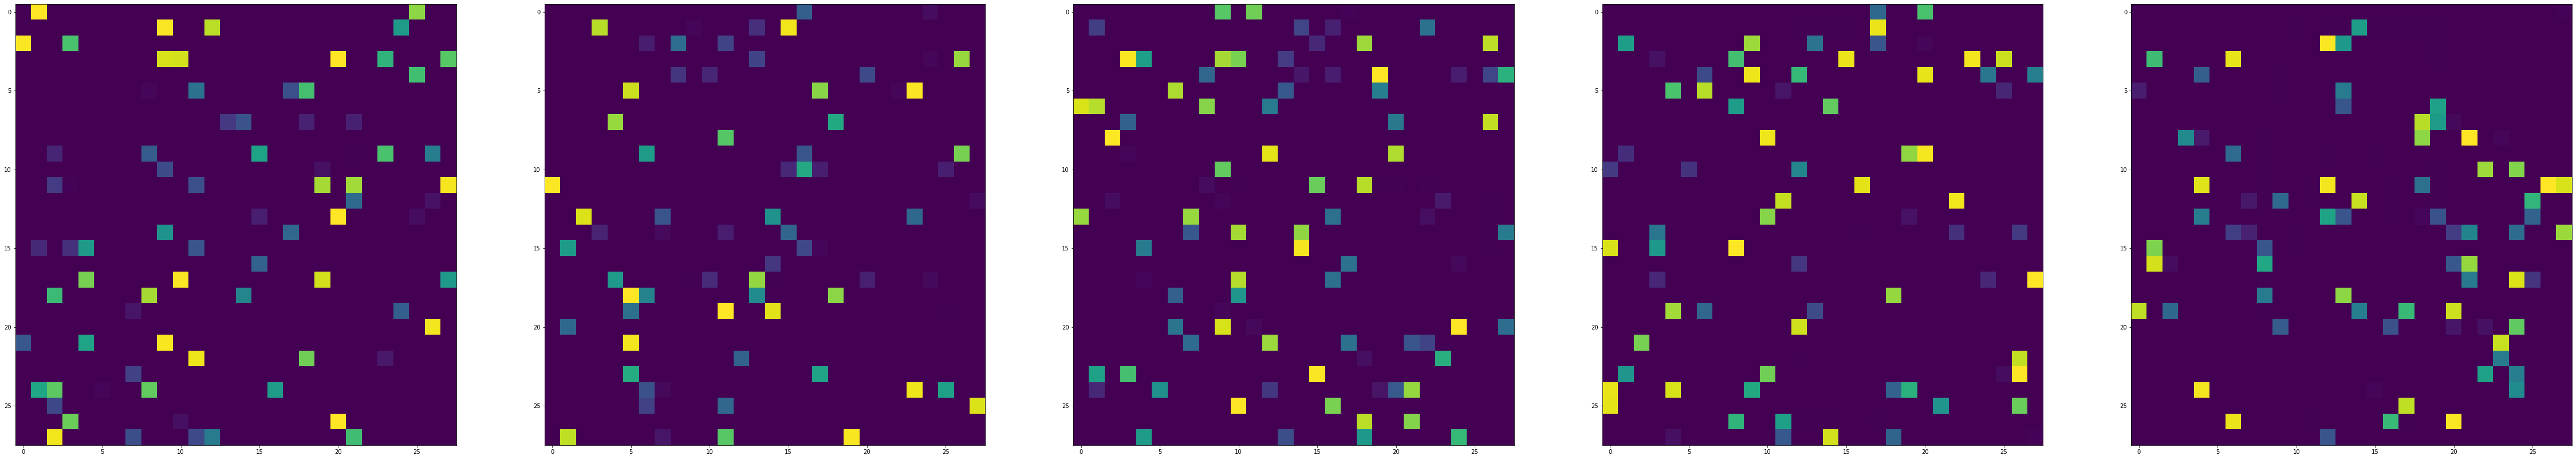

In [18]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

Lets now create the model architecture for the autoencoder. Lets understand what type of network needs to be created for this problem.

Encoding Architecture:

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.

Decoding Architecture:

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well. Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space.

In [19]:
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [20]:
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)         

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='max')
history = model_2.fit(train_x_n, train_x, epochs=20, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/20
27/27 [==============================] - 87s 3s/step - loss: 1.5400 - val_loss: 0.1327
Epoch 2/20
27/27 [==============================] - 87s 3s/step - loss: 0.1207 - val_loss: 0.1103
Epoch 3/20
23/27 [========================>.....] - ETA: 12s - loss: 0.1071

In [ ]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

Sequence to Sequence Prediction using AutoEncoders¶

Autoencoder Architecture
The architecuture of this use case will contain an encoder to encode the source sequence and second to decode the encoded source sequence into the target sequence, called the decoder. First lets understand the internal working of LSTMs which will be used in this architecture.

The Long Short-Term Memory, or LSTM, is a recurrent neural network that is comprised of internal gates.
Unlike other recurrent neural networks, the network’s internal gates allow the model to be trained successfully using backpropagation through time, or BPTT, and avoid the vanishing gradients problem.
We can define the number of LSTM memory units in the LSTM layer, Each unit or cell within the layer has an internal memory / cell state, often abbreviated as “c“, and outputs a hidden state, often abbreviated as “h“.
By using Keras, we can access both output states of the LSTM layer as well as the current states of the LSTM layers.
Lets now create an autoencoder architecutre for learning and producing sequences made up of LSTM layers. There are two components:

An encoder architecture which takes a sequence as input and returns the current state of LSTM as the output
A decoder architecture which takes the sequence and encoder LSTM states as input and returns the decoded output sequence
We are saving and accessing hidden and memory states of LSTM so that we can use them while generating predictions on unseen data.
Lets first of all, generate a sequence dataset containing random sequences of fixed lengths. We will create a function to generate random sequences.

X1 repersents the input sequence containing random numbers
X2 repersents the padded sequence which is used as the seed to reproduce the other elements of the sequence
y repersents the target sequence or the actual sequence

In [ ]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples):
        ## create random numbers sequence - input 
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        
        ## create target sequence
        target = inp_seq[:n_out]
    
        ## create padded sequence / seed sequence 
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]  
        
        # convert the elements to categorical using keras api
        X1.append(to_categorical([inp_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
    
    # remove unnecessary dimention
    X1 = np.squeeze(np.array(X1), axis=1) 
    X2 = np.squeeze(np.array(X2), axis=1) 
    y  = np.squeeze(np.array(y), axis=1) 
    return X1, X2, y

samples = 100000
features = 51
inp_size = 6
out_size = 3

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
print("Shapes: ", inputs.shape, seeds.shape, outputs.shape)
print ("Here is first categorically encoded input sequence looks like: ", )
inputs[0][0]

In [ ]:
def define_models(n_input, n_output):
    ## define the encoder architecture 
    ## input : sequence 
    ## output : encoder states 
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    ## define the encoder-decoder architecture 
    ## input : a seed sequence 
    ## output : decoder states, decoded output 
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    ## define the decoder model
    ## input : current states + encoded sequence
    ## output : decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

In [ ]:
encoder_model.summary()

In [ ]:
decoder_model.summary()

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
autoencoder.fit([inputs, seeds], outputs, epochs=1)

In [ ]:
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)

    current_state = encoder.predict(sequence)
    for t in range(out_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    return np.array(output)

In [ ]:
for k in range(5):
    X1, X2, y = dataset_preparation(inp_size, out_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\nInput Sequence=%s SeedSequence=%s, PredictedSequence=%s' 
          % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))